#CDIA:::AAI - Blind Search Methods -- BFS-DFS-DLS-IDS

Ibai Laña

In this notebook we will write a generalized version of BFS and BFS_g that can work with any problem once it is formulated. Then, the key of the solution will be generating proper problem formulations. Some modifications will be made to methods developed in previous work.

Besides, we will introduce modifications to BFS and BSF_g to obtain

*   DFS and DFS_g
*   DLS and DLS_g
*   IDS and IDS_g

## Frontier operation Functions
As we have seen, the frontier is encoded as a FIFO queue, that can be represented in Python as a simple list from where we can add or remove elements.

For DFS, a LIFO stack is the solution, and it will operate similarly but taking the last value instead of the first. As this functions are basically a line, we will include them in the main function

for pushing:
```
 frontier.append(state)
```

for pulling from FIFO queue:
```
state = frontier[0]
frontier = frontier[1:]
```

for popping from LIFO stack:
```
state = frontier[-1]
frontier = frontier[:-1]
```


## PROBLEM FORMULATION
The problem was formulated as a Python class, with the actions, restrictions and functions integrated and always the same name, so they can be re-coded for different problems and the search methods work the same. We start creating the class for River crossing problem. Creating other problems will only require changing some parts of this class.

In [ ]:
class Problem:
    #attributes of the class are empty
    name = ""
    initial_state = {}
    goal_state = {}
    actions = []
  #other attributes could include costs of actions required for other problems.

    def __init__(self): ## init method is the constructor.  When an object is created, this routine is run
  ## in River corssing problem all class attributes are default. But some problems could have parameters
  ## that are used to initialize, for example the initial state.
        self.name ="RiverCrossingProblem"
        self.initial_state = {"Farmer":"L","Wolf":"L","Goat":"L","Cabbage":"L"} ### for this problem, this
        self.goal_state = {"Farmer":"R","Wolf":"R","Goat":"R","Cabbage":"R"} ## for this problem this is not necessary, as we will have a method to define if the goal state has arrived
        self.actions = ["Farmer", "Wolf", "Goat", "Cabbage"]


  # this function should exist for all problems, but its internal operation should be changed per problem
    def is_final_state(self, state):
        return all(value == "R" for value in state.values())



  # this function is only required for River Crossing problem, other problems could have other functions to assist changing states
    def change_element_status (self, element, state):
        if state[element]=="R":
            return "L"
        else:
            return "R"

  ## MOve function is replaced by two functions:
  # "is_applicable", that checks if a new state is possible (it was called check_possible_state)
  # "effect", that applies the action if it is possible.

    # this function should exist for all problems, but its internal operation should be changed per problem
    def is_applicable (self, state):
        #in River crossing, we just check that impossible states are not produced
        comprobation_wolf_goat = not ((state["Wolf"]==state["Goat"]) & (state["Wolf"]!=state["Farmer"]))
        comprobation_goat_cabbage = not ((state["Cabbage"]==state["Goat"]) & (state["Goat"]!=state["Farmer"]))
        return comprobation_wolf_goat and comprobation_goat_cabbage

    # this function should exist for all problems, but its internal operation should be changed per problem
    # in this case, the applicability is checked in the expansion function, so the effect of a change is always produced
    def effect (self, state, action):
        #in River crossing, this function was "move" function
        new_state=state.copy()
        if action=="Farmer":
          #change the status to the new one in the new state
          new_state["Farmer"]=self.change_element_status(action, state)
        else: #if any other element is to be moved, first, check if it is in teh same side as the farmer
            new_state["Farmer"]=self.change_element_status("Farmer", state)
            new_state[action]=self.change_element_status(action, state)
        return new_state #


# we also need cost of an action adn evaluation of the state, for other problems. for River crossing they are defined and return just 1
    def get_cost(self, action, state):
        return 1

    def get_evaluation (self, state):
        return 1


Now we can create objects of the class Problem that will have all of the methods and attributes to use.

In [ ]:
riverproblem = Problem()
riverproblem.is_applicable({"Farmer":"R","Wolf":"R","Goat":"L","Cabbage":"L"})

False

In [ ]:
new_state  = riverproblem.effect({"Farmer":"L","Wolf":"R","Goat":"L","Cabbage":"L"}, "Cabbage")
riverproblem.is_applicable(new_state)

True

In [ ]:
#moving a forbidden element
new_state  = riverproblem.effect({"Farmer":"L","Wolf":"R","Goat":"L","Cabbage":"L"}, "Wolf")
print (new_state)
riverproblem.is_applicable(new_state)

{'Farmer': 'R', 'Wolf': 'L', 'Goat': 'L', 'Cabbage': 'L'}


False

In [ ]:
#moving to an impossible state
new_state  = riverproblem.effect({"Farmer":"L","Wolf":"L","Goat":"L","Cabbage":"L"}, "Cabbage")
print ( new_state)
riverproblem.is_applicable(new_state)

{'Farmer': 'R', 'Wolf': 'L', 'Goat': 'L', 'Cabbage': 'R'}


False

# Generalized Expansion Function
The function is similar but it does not include the particular actions of River Crossing problems, but calls to the problem functions, that will be specific for each problem

It receives the problem, with the functions and actions, and a NODE, which includes the following:

* state	(current state)
* parent node (parent node, starts with empty)
* actions (list of actions that led here)
* cost (starting in 0)
* depth (starting in 0)
* evaluation

these fields are not necessary for River Crossing problem but we will use them for other problems


In [ ]:
# instead of updating the frontier, the expand function only creates a list of child of possible nodes given a current node
# it does not receive states, but NODES, dictionaries that include other information besides state
def expand (node, problem):
    new_nodes = []
    possible_actions = problem.actions
    for action in possible_actions:
        new_state= problem.effect (node["state"], action)
        if problem.is_applicable(new_state):
            new_node = {}
            new_node["state"]=new_state
            new_node["parent_node"]=node
            new_node["actions"]=node["actions"] + [action]
            new_node["cost"]=problem.get_cost(action, node["state"])
            new_node["depth"]=node["depth"]+1
            new_node["evaluation"]=problem.get_evaluation(new_state)
            new_nodes.append (new_node)
    return new_nodes


# BFS - Breadth First Search

```
1. Make a node with the initial problem state
2. Insert node into the frontier data structure
3. WHILE final state not found AND frontier is not empty DO
  3.1 Remove first node from the frontier
  3.2 IF node contains final state THEN final state found
  3.3 IF node doesn’t contain final state THEN
     3.3.1 EXPAND node’s state
     3.3.2 Insert successor nodes into frontier
4. IF final state found THEN
  4.1  RETURN sequence of actions found
5. ELSE  “solution not found”
```

We are maintaing previous coding but generalized to new methods. Besides, we are creating a result dictionary that contains result info so we can use it later

In [ ]:
def BFS(problem):
    # result dictionary
    result = {"method":"BFS", "final_state":[], "status":"No nodes in the frontier. No solution possible.",
             "max_frontier":0, "max_depth":0, "iterations":0}

    # 1. problem definition
    problem = Problem()
    initial_node={"state":problem.initial_state, "parent_node":{}, "actions":[], "cost":0, "depth":0, "evaluation":1}
    frontier = []

     # 2. add node to frontier
    frontier.append(initial_node)

    # 3. start exploring and expanding the frontier
    iterations=1
    while len (frontier)>0: #if we have elements in the frontier...
         # 3.1. get first element of frontier and delete it
        node = frontier[0]


        frontier = frontier[1:]
        # 3.2 check if it is final state:
        if problem.is_final_state (node["state"]):
            result["status"]="Solution Found."
            break #we end while. state will remain this last state computed, and sequence of actions will have all states.

        # 3.3 if it is not final, expand and add to the frontier
        new_nodes = expand(node, problem)
        for n in new_nodes:
            frontier.append(n)

        # we compute the maximum size of frontier: the previous one or the current if it is bigger
        result["max_frontier"]=max(result["max_frontier"],len (frontier))
         # we compute the maximum depth: the previous one or the current if it is bigger
        result["max_depth"]=max(result["max_depth"], node["depth"])
         # we update the iterations count
        result["iterations"]= iterations

        iterations+=1
      #loop keeps running until no more nodes available or final state obtained

    result["final_state"] = node
    return(result)




In [ ]:
problem=Problem()
problem.initial_state
result = BFS(problem)
print (result)

{'method': 'BFS', 'final_state': {'state': {'Farmer': 'R', 'Wolf': 'R', 'Goat': 'R', 'Cabbage': 'R'}, 'parent_node': {'state': {'Farmer': 'L', 'Wolf': 'R', 'Goat': 'L', 'Cabbage': 'R'}, 'parent_node': {'state': {'Farmer': 'R', 'Wolf': 'R', 'Goat': 'L', 'Cabbage': 'R'}, 'parent_node': {'state': {'Farmer': 'L', 'Wolf': 'R', 'Goat': 'L', 'Cabbage': 'L'}, 'parent_node': {'state': {'Farmer': 'R', 'Wolf': 'R', 'Goat': 'R', 'Cabbage': 'L'}, 'parent_node': {'state': {'Farmer': 'L', 'Wolf': 'L', 'Goat': 'R', 'Cabbage': 'L'}, 'parent_node': {'state': {'Farmer': 'R', 'Wolf': 'L', 'Goat': 'R', 'Cabbage': 'L'}, 'parent_node': {'state': {'Farmer': 'L', 'Wolf': 'L', 'Goat': 'L', 'Cabbage': 'L'}, 'parent_node': {}, 'actions': [], 'cost': 0, 'depth': 0, 'evaluation': 1}, 'actions': ['Goat'], 'cost': 1, 'depth': 1, 'evaluation': 1}, 'actions': ['Goat', 'Farmer'], 'cost': 1, 'depth': 2, 'evaluation': 1}, 'actions': ['Goat', 'Farmer', 'Wolf'], 'cost': 1, 'depth': 3, 'evaluation': 1}, 'actions': ['Goat', '

# BFS-g: Breadth First Search with Graphs
Same as BFS but with the expanded nodes list

In [ ]:
def BFS_g(problem):
    # result dictionary
    result = {"method":"BFS_g", "final_state":[], "status":"No nodes in the frontier. No solution possible.",
             "max_frontier":0, "max_depth":0, "iterations":0}

    # 1. problem definition
    problem = Problem()
    initial_node={"state":problem.initial_state, "parent_node":{}, "actions":[], "cost":0, "depth":0, "evaluation":1}
    frontier = []

    ####
    expanded = []

     # 2. add node to frontier
    frontier.append(initial_node)

    # 3. start exploring and expanding the frontier
    iterations=1
    while len (frontier)>0: #if we have elements in the frontier...
         # 3.1. get first element of frontier and delete it
        node = frontier[0]
        frontier = frontier[1:]

        #add to expanded--> we add the state, as the rest of fields will be different
        expanded.append(node["state"])

        # 3.2 check if it is final state:
        if problem.is_final_state (node["state"]):
            result["status"]="Solution Found."
            break #we end while. state will remain this last state computed, and sequence of actions will have all states.

        # 3.3 if it is not final, expand and add to the frontier
        new_nodes = expand(node, problem)
        for n in new_nodes:
            # check if it is expanded before adding to frontier
            if n["state"] not in expanded:
                frontier.append(n)

        # we compute the maximum size of frontier: the previous one or the current if it is bigger
        result["max_frontier"]=max(result["max_frontier"],len (frontier))
         # we compute the maximum depth: the previous one or the current if it is bigger
        result["max_depth"]=max(result["max_depth"], node["depth"])
         # we update the iterations count
        result["iterations"]= iterations

        iterations+=1
      #loop keeps running until no more nodes available or final state obtained

    result["final_state"] = node
    return(result)

In [ ]:
problem=Problem()
problem.initial_state
result = BFS_g(problem)
print (result)

{'method': 'BFS_g', 'final_state': {'state': {'Farmer': 'R', 'Wolf': 'R', 'Goat': 'R', 'Cabbage': 'R'}, 'parent_node': {'state': {'Farmer': 'L', 'Wolf': 'R', 'Goat': 'L', 'Cabbage': 'R'}, 'parent_node': {'state': {'Farmer': 'R', 'Wolf': 'R', 'Goat': 'L', 'Cabbage': 'R'}, 'parent_node': {'state': {'Farmer': 'L', 'Wolf': 'R', 'Goat': 'L', 'Cabbage': 'L'}, 'parent_node': {'state': {'Farmer': 'R', 'Wolf': 'R', 'Goat': 'R', 'Cabbage': 'L'}, 'parent_node': {'state': {'Farmer': 'L', 'Wolf': 'L', 'Goat': 'R', 'Cabbage': 'L'}, 'parent_node': {'state': {'Farmer': 'R', 'Wolf': 'L', 'Goat': 'R', 'Cabbage': 'L'}, 'parent_node': {'state': {'Farmer': 'L', 'Wolf': 'L', 'Goat': 'L', 'Cabbage': 'L'}, 'parent_node': {}, 'actions': [], 'cost': 0, 'depth': 0, 'evaluation': 1}, 'actions': ['Goat'], 'cost': 1, 'depth': 1, 'evaluation': 1}, 'actions': ['Goat', 'Farmer'], 'cost': 1, 'depth': 2, 'evaluation': 1}, 'actions': ['Goat', 'Farmer', 'Wolf'], 'cost': 1, 'depth': 3, 'evaluation': 1}, 'actions': ['Goat',

# DFS: Depth First Search
The only change with respect to BFS is in the step 3.1, where we take out of the frontier the last node

In [ ]:
def DFS(problem):
    # result dictionary
    result = {"method":"DFS", "final_state":[], "status":"No nodes in the frontier. No solution possible.",
             "max_frontier":0, "max_depth":0, "iterations":0}

    # 1. problem definition
    problem = Problem()
    initial_node={"state":problem.initial_state, "parent_node":{}, "actions":[], "cost":0, "depth":0, "evaluation":1}
    frontier = []

     # 2. add node to frontier
    frontier.append(initial_node)

    # 3. start exploring and expanding the frontier
    iterations=1
    while len (frontier)>0: #if we have elements in the frontier...
         # 3.1. get LAST element of frontier and delete it
        node = frontier[-1]
        frontier = frontier[:-1]

        # 3.2 check if it is final state:
        if problem.is_final_state (node["state"]):
            result["status"]="Solution Found."
            break #we end while. state will remain this last state computed, and sequence of actions will have all states.

        # 3.3 if it is not final, expand and add to the frontier
        new_nodes = expand(node, problem)
        for n in new_nodes:
            frontier.append(n)

        # we compute the maximum size of frontier: the previous one or the current if it is bigger
        result["max_frontier"]=max(result["max_frontier"],len (frontier))
         # we compute the maximum depth: the previous one or the current if it is bigger
        result["max_depth"]=max(result["max_depth"], node["depth"])
         # we update the iterations count
        result["iterations"]= iterations

        iterations+=1
        print (iterations)
      #loop keeps running until no more nodes available or final state obtained

    result["final_state"] = node
    return(result)

In [ ]:
problem=Problem()
problem.initial_state
result = DFS(problem)
print (result)

Se han truncado las últimas 5000 líneas del flujo de salida.
7658
7659
7660
7661
7662
7663
7664
7665
7666
7667
7668
7669
7670
7671
7672
7673
7674
7675
7676
7677
7678
7679
7680
7681
7682
7683
7684
7685
7686
7687
7688
7689
7690
7691
7692
7693
7694
7695
7696
7697
7698
7699
7700
7701
7702
7703
7704
7705
7706
7707
7708
7709
7710
7711
7712
7713
7714
7715
7716
7717
7718
7719
7720
7721
7722
7723
7724
7725
7726
7727
7728
7729
7730
7731
7732
7733
7734
7735
7736
7737
7738
7739
7740
7741
7742
7743
7744
7745
7746
7747
7748
7749
7750
7751
7752
7753
7754
7755
7756
7757
7758
7759
7760
7761
7762
7763
7764
7765
7766
7767
7768
7769
7770
7771
7772
7773
7774
7775
7776
7777
7778
7779
7780
7781
7782
7783
7784
7785
7786
7787
7788
7789
7790
7791
7792
7793
7794
7795
7796
7797
7798
7799
7800
7801
7802
7803
7804
7805
7806
7807
7808
7809
7810
7811
7812
7813
7814
7815
7816
7817
7818
7819
7820
7821
7822
7823
7824
7825
7826
7827
7828
7829
7830
7831
7832
7833
7834
7835
7836
7837
7838
7839
7840
7841
7842
7843
7844
7845

KeyboardInterrupt: ignored

**We have an infinite loop here!**

Why?

In principle, the method should work going throuhg the nodes down and be much quicker than BFS. The thing here is the expansion on the "center" side of the tree is the one that leads to a solution. But the stack implementation leads to exploring the "right" branch, leading to an infinite loop. We could simply change the statemente of the problem and the order of actions to have a solution that works.

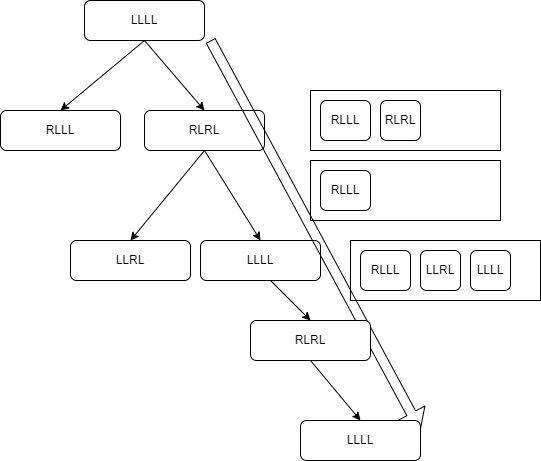

# DFS_g - Depth First Search with Graph Search
The only change with respect to BFS.gs is in the step 3.1, where we take out of the frontier the last node



In [ ]:
def DFS_g(problem):
    # result dictionary
    result = {"method":"DFS_g", "final_state":[], "status":"No nodes in the frontier. No solution possible.",
             "max_frontier":0, "max_depth":0, "iterations":0}

    # 1. problem definition
    problem = Problem()
    initial_node={"state":problem.initial_state, "parent_node":{}, "actions":[], "cost":0, "depth":0, "evaluation":1}
    frontier = []

    ####
    expanded = []

     # 2. add node to frontier
    frontier.append(initial_node)

    # 3. start exploring and expanding the frontier
    iterations=1
    while len (frontier)>0: #if we have elements in the frontier...
         # 3.1. get first element of frontier and delete it
        node = frontier[-1]
        frontier = frontier[:-1]

        #add to expanded--> we add the state, as the rest of fields will be different
        expanded.append(node["state"])

        # 3.2 check if it is final state:
        if problem.is_final_state (node["state"]):
            result["status"]="Solution Found."
            break #we end while. state will remain this last state computed, and sequence of actions will have all states.

        # 3.3 if it is not final, expand and add to the frontier
        new_nodes = expand(node, problem)
        for n in new_nodes:
            # check if it is expanded before adding to frontier
            if n["state"] not in expanded:
                frontier.append(n)

        # we compute the maximum size of frontier: the previous one or the current if it is bigger
        result["max_frontier"]=max(result["max_frontier"],len (frontier))
         # we compute the maximum depth: the previous one or the current if it is bigger
        result["max_depth"]=max(result["max_depth"], node["depth"])
         # we update the iterations count
        result["iterations"]= iterations

        iterations+=1
      #loop keeps running until no more nodes available or final state obtained

    result["final_state"] = node
    return(result)

In [ ]:
problem=Problem()
problem.initial_state
result = DFS_g(problem)
print (result)

{'method': 'DFS_g', 'final_state': {'state': {'Farmer': 'R', 'Wolf': 'R', 'Goat': 'R', 'Cabbage': 'R'}, 'parent_node': {'state': {'Farmer': 'L', 'Wolf': 'R', 'Goat': 'L', 'Cabbage': 'R'}, 'parent_node': {'state': {'Farmer': 'R', 'Wolf': 'R', 'Goat': 'L', 'Cabbage': 'R'}, 'parent_node': {'state': {'Farmer': 'L', 'Wolf': 'L', 'Goat': 'L', 'Cabbage': 'R'}, 'parent_node': {'state': {'Farmer': 'R', 'Wolf': 'L', 'Goat': 'R', 'Cabbage': 'R'}, 'parent_node': {'state': {'Farmer': 'L', 'Wolf': 'L', 'Goat': 'R', 'Cabbage': 'L'}, 'parent_node': {'state': {'Farmer': 'R', 'Wolf': 'L', 'Goat': 'R', 'Cabbage': 'L'}, 'parent_node': {'state': {'Farmer': 'L', 'Wolf': 'L', 'Goat': 'L', 'Cabbage': 'L'}, 'parent_node': {}, 'actions': [], 'cost': 0, 'depth': 0, 'evaluation': 1}, 'actions': ['Goat'], 'cost': 1, 'depth': 1, 'evaluation': 1}, 'actions': ['Goat', 'Farmer'], 'cost': 1, 'depth': 2, 'evaluation': 1}, 'actions': ['Goat', 'Farmer', 'Cabbage'], 'cost': 1, 'depth': 3, 'evaluation': 1}, 'actions': ['Goa

# DLS - Depth Limited Search
The only change with respect to DFS is the check for not violating the limits before including a node in the frontier

In [ ]:
def DLS(problem, depth_limit, iteration_limit):
    # result dictionary
    result = {"method":"DLS"+str(depth_limit), "final_state":[], "status":"No nodes in the frontier. No solution possible.",
             "max_frontier":0, "max_depth":0, "iterations":0}

    # 1. problem definition
    problem = Problem()
    initial_node={"state":problem.initial_state, "parent_node":{}, "actions":[], "cost":0, "depth":0, "evaluation":1}
    frontier = []

     # 2. add node to frontier
    frontier.append(initial_node)

    # 3. start exploring and expanding the frontier
    iterations=1
    while len (frontier)>0: #if we have elements in the frontier...
         #before doing anything, if we have reached the iteration limit, stop
        if iterations>iteration_limit:
            result["status"] = "Maximum number of iterations reached"
            break

         # 3.1. get LAST element of frontier and delete it
        node = frontier[-1]
        frontier = frontier[:-1]

        # 3.2 check if it is final state:
        if problem.is_final_state (node["state"]):
            result["status"]="Solution Found."
            break #we end while. state will remain this last state computed, and sequence of actions will have all states.

        # 3.3 if it is not final, expand and add to the frontier
        new_nodes = expand(node, problem)
        for n in new_nodes:
            ##### WE ONLY APPEND IF DEPTH <= LIMIT
            if n["depth"]<=depth_limit:
                frontier.append(n)
            #in other case node is not appended, ending the loop

        # we compute the maximum size of frontier: the previous one or the current if it is bigger
        result["max_frontier"]=max(result["max_frontier"],len (frontier))
         # we compute the maximum depth: the previous one or the current if it is bigger
        result["max_depth"]=max(result["max_depth"], node["depth"])
         # we update the iterations count
        result["iterations"]= iterations

        iterations+=1
      #loop keeps running until no more nodes available or final state obtained

    result["final_state"] = node
    return(result)

In [ ]:
problem=Problem()
result = DLS(problem, 6, 100)
print (result)


{'method': 'DLS6', 'final_state': {'state': {'Farmer': 'L', 'Wolf': 'L', 'Goat': 'R', 'Cabbage': 'L'}, 'parent_node': {'state': {'Farmer': 'R', 'Wolf': 'L', 'Goat': 'R', 'Cabbage': 'L'}, 'parent_node': {'state': {'Farmer': 'L', 'Wolf': 'L', 'Goat': 'R', 'Cabbage': 'L'}, 'parent_node': {'state': {'Farmer': 'R', 'Wolf': 'L', 'Goat': 'R', 'Cabbage': 'L'}, 'parent_node': {'state': {'Farmer': 'L', 'Wolf': 'L', 'Goat': 'R', 'Cabbage': 'L'}, 'parent_node': {'state': {'Farmer': 'R', 'Wolf': 'L', 'Goat': 'R', 'Cabbage': 'L'}, 'parent_node': {'state': {'Farmer': 'L', 'Wolf': 'L', 'Goat': 'L', 'Cabbage': 'L'}, 'parent_node': {}, 'actions': [], 'cost': 0, 'depth': 0, 'evaluation': 1}, 'actions': ['Goat'], 'cost': 1, 'depth': 1, 'evaluation': 1}, 'actions': ['Goat', 'Farmer'], 'cost': 1, 'depth': 2, 'evaluation': 1}, 'actions': ['Goat', 'Farmer', 'Farmer'], 'cost': 1, 'depth': 3, 'evaluation': 1}, 'actions': ['Goat', 'Farmer', 'Farmer', 'Farmer'], 'cost': 1, 'depth': 4, 'evaluation': 1}, 'actions':

In [ ]:
result = DLS(problem, 7, 100)
print (result)

{'method': 'DLS7', 'final_state': {'state': {'Farmer': 'R', 'Wolf': 'R', 'Goat': 'R', 'Cabbage': 'R'}, 'parent_node': {'state': {'Farmer': 'L', 'Wolf': 'R', 'Goat': 'L', 'Cabbage': 'R'}, 'parent_node': {'state': {'Farmer': 'R', 'Wolf': 'R', 'Goat': 'L', 'Cabbage': 'R'}, 'parent_node': {'state': {'Farmer': 'L', 'Wolf': 'L', 'Goat': 'L', 'Cabbage': 'R'}, 'parent_node': {'state': {'Farmer': 'R', 'Wolf': 'L', 'Goat': 'R', 'Cabbage': 'R'}, 'parent_node': {'state': {'Farmer': 'L', 'Wolf': 'L', 'Goat': 'R', 'Cabbage': 'L'}, 'parent_node': {'state': {'Farmer': 'R', 'Wolf': 'L', 'Goat': 'R', 'Cabbage': 'L'}, 'parent_node': {'state': {'Farmer': 'L', 'Wolf': 'L', 'Goat': 'L', 'Cabbage': 'L'}, 'parent_node': {}, 'actions': [], 'cost': 0, 'depth': 0, 'evaluation': 1}, 'actions': ['Goat'], 'cost': 1, 'depth': 1, 'evaluation': 1}, 'actions': ['Goat', 'Farmer'], 'cost': 1, 'depth': 2, 'evaluation': 1}, 'actions': ['Goat', 'Farmer', 'Cabbage'], 'cost': 1, 'depth': 3, 'evaluation': 1}, 'actions': ['Goat

Just by adding the limit we avoid the infinite loop situations. Besides, we can check where is the depth required to solve the problem, in this case with 6 is not enough, but 7 does the trick.

#DLS_g - Depth Limited Search with Graph Search
The only change with respect to DFS_g is the check for not violating the limit before including a node in the frontier

In [ ]:
def DLS_g(problem, depth_limit, iteration_limit):
    # result dictionary
    result = {"method":"DLS_g-"+str(depth_limit), "final_state":[], "status":"No nodes in the frontier. No solution possible.",
             "max_frontier":0, "max_depth":0, "iterations":0}

    # 1. problem definition
    problem = Problem()
    initial_node={"state":problem.initial_state, "parent_node":{}, "actions":[], "cost":0, "depth":0, "evaluation":1}
    frontier = []

    ####
    expanded = []

     # 2. add node to frontier
    frontier.append(initial_node)

    # 3. start exploring and expanding the frontier
    iterations=1
    while len (frontier)>0: #if we have elements in the frontier...
       #before doing anything, if we have reached the iteration limit, stop
        if iterations>iteration_limit:
            result["status"] = "Maximum number of iterations reached"
            break
         # 3.1. get first element of frontier and delete it
        node = frontier[-1]
        frontier = frontier[:-1]

        #add to expanded--> we add the state, as the rest of fields will be different
        expanded.append(node["state"])

        # 3.2 check if it is final state:
        if problem.is_final_state (node["state"]):
            result["status"]="Solution Found."
            break #we end while. state will remain this last state computed, and sequence of actions will have all states.

        # 3.3 if it is not final, expand and add to the frontier
        new_nodes = expand(node, problem)
        for n in new_nodes:
            # check if it is expanded before adding to frontier
            if n["state"] not in expanded:
                if n["depth"]<=depth_limit:
                    frontier.append(n)

        # we compute the maximum size of frontier: the previous one or the current if it is bigger
        result["max_frontier"]=max(result["max_frontier"],len (frontier))
         # we compute the maximum depth: the previous one or the current if it is bigger
        result["max_depth"]=max(result["max_depth"], node["depth"])
         # we update the iterations count
        result["iterations"]= iterations

        iterations+=1
      #loop keeps running until no more nodes available or final state obtained

    result["final_state"] = node
    return(result)

In [ ]:
problem=Problem()
result = DLS_g(problem, 7, 100)
print (result)


{'method': 'DLS_g-7', 'final_state': {'state': {'Farmer': 'R', 'Wolf': 'R', 'Goat': 'R', 'Cabbage': 'R'}, 'parent_node': {'state': {'Farmer': 'L', 'Wolf': 'R', 'Goat': 'L', 'Cabbage': 'R'}, 'parent_node': {'state': {'Farmer': 'R', 'Wolf': 'R', 'Goat': 'L', 'Cabbage': 'R'}, 'parent_node': {'state': {'Farmer': 'L', 'Wolf': 'L', 'Goat': 'L', 'Cabbage': 'R'}, 'parent_node': {'state': {'Farmer': 'R', 'Wolf': 'L', 'Goat': 'R', 'Cabbage': 'R'}, 'parent_node': {'state': {'Farmer': 'L', 'Wolf': 'L', 'Goat': 'R', 'Cabbage': 'L'}, 'parent_node': {'state': {'Farmer': 'R', 'Wolf': 'L', 'Goat': 'R', 'Cabbage': 'L'}, 'parent_node': {'state': {'Farmer': 'L', 'Wolf': 'L', 'Goat': 'L', 'Cabbage': 'L'}, 'parent_node': {}, 'actions': [], 'cost': 0, 'depth': 0, 'evaluation': 1}, 'actions': ['Goat'], 'cost': 1, 'depth': 1, 'evaluation': 1}, 'actions': ['Goat', 'Farmer'], 'cost': 1, 'depth': 2, 'evaluation': 1}, 'actions': ['Goat', 'Farmer', 'Cabbage'], 'cost': 1, 'depth': 3, 'evaluation': 1}, 'actions': ['G

# IDS - Iterative Deepening Search
The difference with DLS is in the increase of the limit once the frontier get empty, and the increase of the limit.
We will have to change the while condition in order to control the ending of the frontier. Now if the frontier is empty it can be the end of the process or not, depending on the depth

In [ ]:
def IDS(problem, depth_limit, iteration_limit):
    # result dictionary
    result = {"method":"IDS"+str(depth_limit), "final_state":[], "status":"No nodes in the frontier. No solution possible.",
             "max_frontier":0, "max_depth":0, "iterations":0}

    # 1. problem definition
    problem = Problem()
    initial_node={"state":problem.initial_state, "parent_node":{}, "actions":[], "cost":0, "depth":0, "evaluation":1}
    frontier = []

     # 2. add node to frontier
    frontier.append(initial_node)

    # 3. start exploring and expanding the frontier
    iterations=1

    # we add a control of the accepted max depth, starting with 1:
    current_max_depth=1

    #change the loop condition, now we have to control the end of the loop inside it
    while True:
    for max_depth in range (1,depth_limit)
        #if the len is 0, we have reached to the end of the depth. We start again with an increased max depth
        if len (frontier)==0:
            if current_max_depth<depth_limit:
                current_max_depth+=1
                node ={"state":problem.initial_state, "parent_node":{}, "actions":[], "cost":0, "depth":0, "evaluation":1}
                frontier.append(node)
            else:
                result["status"]= "No nodes in the frontier. No solution possible."
                break

        #control if we have reached the iteration limit, stop
        if iterations>iteration_limit:
            result["status"] = "Maximum number of iterations reached"
            break

         # 3.1. get LAST element of frontier and delete it
        node = frontier[-1]
        frontier = frontier[:-1]

        # 3.2 check if it is final state:
        if problem.is_final_state (node["state"]):
            result["status"]="Solution Found."
            break #we end while. state will remain this last state computed, and sequence of actions will have all states.

        # 3.3 if it is not final, expand and add to the frontier
        new_nodes = expand(node, problem)
        for n in new_nodes:
            ##### WE ONLY APPEND IF DEPTH <= CURRENT MAX DEPTH
            if n["depth"]<=current_max_depth:
                frontier.append(n)
            #in other case node is not appended, ending the loop

        # we compute the maximum size of frontier: the previous one or the current if it is bigger
        result["max_frontier"]=max(result["max_frontier"],len (frontier))
         # we compute the maximum depth: the previous one or the current if it is bigger
        result["max_depth"]=max(result["max_depth"], node["depth"])
         # we update the iterations count
        result["iterations"]= iterations

        iterations+=1
      #loop keeps running until no more nodes available or final state obtained

    result["final_state"] = node
    return(result)

In [ ]:
result = IDS(problem, 28, 300)
print (result)

{'method': 'IDS28', 'final_state': {'state': {'Farmer': 'R', 'Wolf': 'R', 'Goat': 'R', 'Cabbage': 'R'}, 'parent_node': {'state': {'Farmer': 'L', 'Wolf': 'R', 'Goat': 'L', 'Cabbage': 'R'}, 'parent_node': {'state': {'Farmer': 'R', 'Wolf': 'R', 'Goat': 'L', 'Cabbage': 'R'}, 'parent_node': {'state': {'Farmer': 'L', 'Wolf': 'L', 'Goat': 'L', 'Cabbage': 'R'}, 'parent_node': {'state': {'Farmer': 'R', 'Wolf': 'L', 'Goat': 'R', 'Cabbage': 'R'}, 'parent_node': {'state': {'Farmer': 'L', 'Wolf': 'L', 'Goat': 'R', 'Cabbage': 'L'}, 'parent_node': {'state': {'Farmer': 'R', 'Wolf': 'L', 'Goat': 'R', 'Cabbage': 'L'}, 'parent_node': {'state': {'Farmer': 'L', 'Wolf': 'L', 'Goat': 'L', 'Cabbage': 'L'}, 'parent_node': {}, 'actions': [], 'cost': 0, 'depth': 0, 'evaluation': 1}, 'actions': ['Goat'], 'cost': 1, 'depth': 1, 'evaluation': 1}, 'actions': ['Goat', 'Farmer'], 'cost': 1, 'depth': 2, 'evaluation': 1}, 'actions': ['Goat', 'Farmer', 'Cabbage'], 'cost': 1, 'depth': 3, 'evaluation': 1}, 'actions': ['Goa

# IDS_g - Iterative Deepening Search with Graph Search

The difference with DLS_g is in the increase of the limit once the frontier get empty, and the increase of the limit.

In [ ]:
def IDS_g(problem, depth_limit, iteration_limit):
    # result dictionary
    result = {"method":"IDS_g-"+str(depth_limit), "final_state":[], "status":"No nodes in the frontier. No solution possible.",
             "max_frontier":0, "max_depth":0, "iterations":0}

    # 1. problem definition
    problem = Problem()
    initial_node={"state":problem.initial_state, "parent_node":{}, "actions":[], "cost":0, "depth":0, "evaluation":1}
    frontier = []

    ####
    expanded = []

     # 2. add node to frontier
    frontier.append(initial_node)

    # 3. start exploring and expanding the frontier
    iterations=1
     # we add a control of the accepted max depth, starting with 1:
    current_max_depth=1

    #change the loop condition, now we have to control the end of the loop inside it
    while True:
        #if the len is 0, we have reached to the end of the depth. We start again with an increased max depth
        if len (frontier)==0:
            if current_max_depth<depth_limit:
                current_max_depth+=1
                node ={"state":problem.initial_state, "parent_node":{}, "actions":[], "cost":0, "depth":0, "evaluation":1}
                frontier.append(node)
                expanded = []
            else:
                result["status"]= "No nodes in the frontier. No solution possible."
                break
       #before doing anything, if we have reached the iteration limit, stop
        if iterations>iteration_limit:
            result["status"] = "Maximum number of iterations reached"
            break
         # 3.1. get first element of frontier and delete it
        node = frontier[-1]
        frontier = frontier[:-1]

        #add to expanded--> we add the state, as the rest of fields will be different
        expanded.append(node["state"])

        # 3.2 check if it is final state:
        if problem.is_final_state (node["state"]):
            result["status"]="Solution Found."
            break #we end while. state will remain this last state computed, and sequence of actions will have all states.

        # 3.3 if it is not final, expand and add to the frontier
        new_nodes = expand(node, problem)
        for n in new_nodes:
            # check if it is expanded before adding to frontier
            if n["state"] not in expanded:
                if n["depth"]<=current_max_depth:
                    frontier.append(n)

        # we compute the maximum size of frontier: the previous one or the current if it is bigger
        result["max_frontier"]=max(result["max_frontier"],len (frontier))
         # we compute the maximum depth: the previous one or the current if it is bigger
        result["max_depth"]=max(result["max_depth"], node["depth"])
         # we update the iterations count
        result["iterations"]= iterations

        iterations+=1
      #loop keeps running until no more nodes available or final state obtained

    result["final_state"] = node
    return(result)

In [ ]:
result = IDS_g(problem, 7, 300)
print (result)

{'method': 'IDS_g-7', 'final_state': {'state': {'Farmer': 'R', 'Wolf': 'R', 'Goat': 'R', 'Cabbage': 'R'}, 'parent_node': {'state': {'Farmer': 'L', 'Wolf': 'R', 'Goat': 'L', 'Cabbage': 'R'}, 'parent_node': {'state': {'Farmer': 'R', 'Wolf': 'R', 'Goat': 'L', 'Cabbage': 'R'}, 'parent_node': {'state': {'Farmer': 'L', 'Wolf': 'L', 'Goat': 'L', 'Cabbage': 'R'}, 'parent_node': {'state': {'Farmer': 'R', 'Wolf': 'L', 'Goat': 'R', 'Cabbage': 'R'}, 'parent_node': {'state': {'Farmer': 'L', 'Wolf': 'L', 'Goat': 'R', 'Cabbage': 'L'}, 'parent_node': {'state': {'Farmer': 'R', 'Wolf': 'L', 'Goat': 'R', 'Cabbage': 'L'}, 'parent_node': {'state': {'Farmer': 'L', 'Wolf': 'L', 'Goat': 'L', 'Cabbage': 'L'}, 'parent_node': {}, 'actions': [], 'cost': 0, 'depth': 0, 'evaluation': 1}, 'actions': ['Goat'], 'cost': 1, 'depth': 1, 'evaluation': 1}, 'actions': ['Goat', 'Farmer'], 'cost': 1, 'depth': 2, 'evaluation': 1}, 'actions': ['Goat', 'Farmer', 'Cabbage'], 'cost': 1, 'depth': 3, 'evaluation': 1}, 'actions': ['G